In [40]:
import os
import gc
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers, layers
from tensorflow.keras.models import Model
from dask import dataframe as dd
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [18]:
# Wczytanie danych z Kaggle
data_dir = '/kaggle/input/jane-street-real-time-market-data-forecasting'
train_file = os.path.join(data_dir, 'train.parquet')  # Plik Parquet
features_file = os.path.join(data_dir, 'features.csv')  # Plik CSV 
batch_size = 100000

# Wczytywanie pliku Parquet wsadowo z Dask
if os.path.exists(train_file):
    print("Wczytywanie danych z pliku Parquet wsadowo...")
    sample_ddf = dd.read_parquet(train_file)  # jako Dask DataFrame
    sample_df = sample_ddf.head(10000)  
    print(f"Liczba wierszy: {len(sample_df)}, liczba kolumn: {len(sample_df.columns)}")
else:
    raise FileNotFoundError(f"Nie znaleziono pliku {train_file}")

if os.path.exists(features_file):
    features_info = pd.read_csv(features_file)
    print(f"Wczytano plik features.csv. Liczba wierszy: {len(features_info)}")
else:
    print("Plik features.csv nie znaleziony.")
    
print("Informacje o fragmencie danych (pandas):")
print(sample_df.info())

Wczytywanie danych z pliku Parquet wsadowo...
Liczba wierszy: 10000, liczba kolumn: 93
Wczytano plik features.csv. Liczba wierszy: 79
Informacje o fragmencie danych (pandas):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 93 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   date_id       10000 non-null  int16   
 1   time_id       10000 non-null  int16   
 2   symbol_id     10000 non-null  int8    
 3   weight        10000 non-null  float32 
 4   feature_00    0 non-null      float32 
 5   feature_01    0 non-null      float32 
 6   feature_02    0 non-null      float32 
 7   feature_03    0 non-null      float32 
 8   feature_04    0 non-null      float32 
 9   feature_05    10000 non-null  float32 
 10  feature_06    10000 non-null  float32 
 11  feature_07    10000 non-null  float32 
 12  feature_08    10000 non-null  float32 
 13  feature_09    10000 non-null  int8    
 14  feature_

Brakujące wartości:
 feature_00    10000
feature_01    10000
feature_02    10000
feature_03    10000
feature_04    10000
feature_15      480
feature_17       80
feature_21    10000
feature_26    10000
feature_27    10000
feature_31    10000
feature_32      192
feature_33      192
feature_39     3407
feature_40     1832
feature_41     2154
feature_42     3407
feature_43     1832
feature_44     2154
feature_45     3023
feature_46     3023
feature_50     1840
feature_51        8
feature_52      440
feature_53     1840
feature_54        8
feature_55      440
feature_58      192
feature_62     3595
feature_63     3415
feature_64     3444
feature_65     3023
feature_66     3023
feature_73      192
feature_74      192
dtype: int64


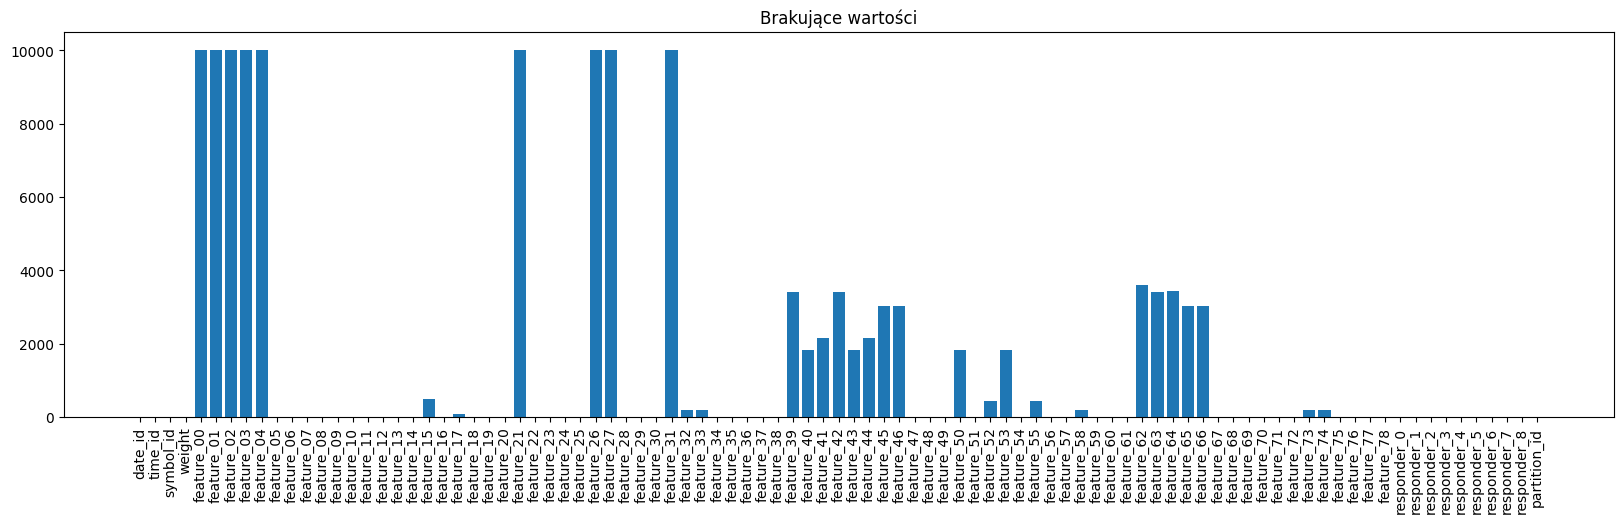

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

missing_values = sample_df.isna().sum()
print("Brakujące wartości:\n", missing_values[missing_values > 0])

# Wizualizacja brakujących wartości
plt.figure(figsize=(20, 5))
plt.bar(sample_df.columns, missing_values)
plt.xticks(rotation=90)
plt.title('Brakujące wartości')
plt.show()

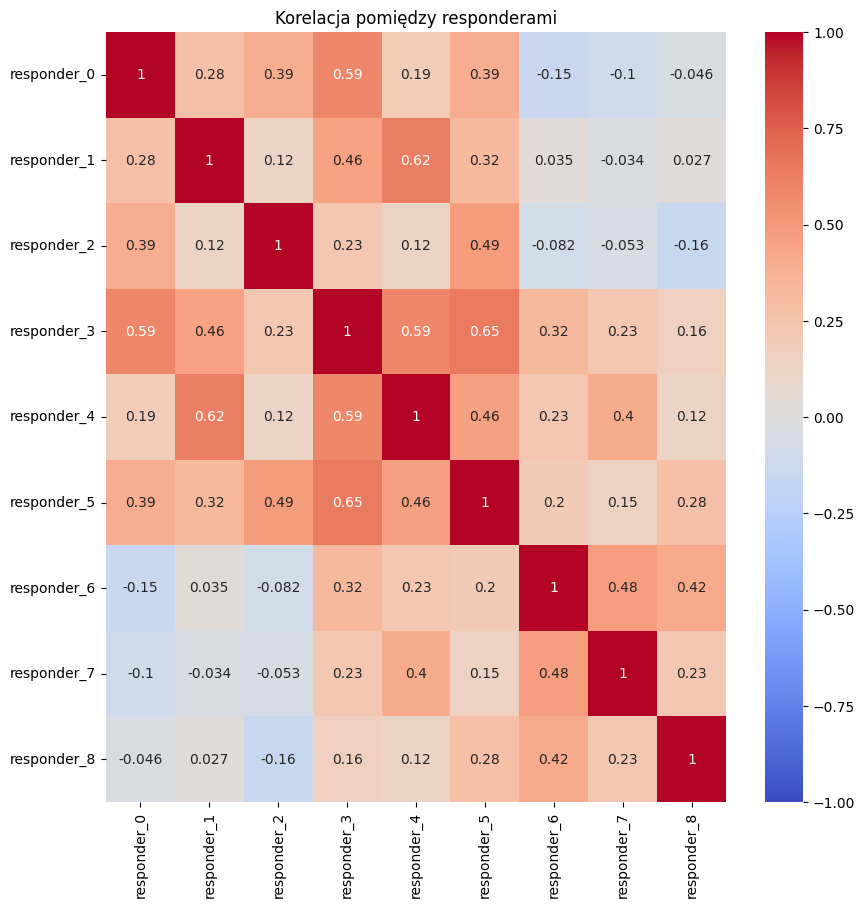

In [57]:
# Analiza korelacji między responderami
responders_columns = [col for col in sample_df.columns if 'responder' in col]

# Korelacja między responderami
correlation_matrix = sample_df[responders_columns].corr()

# Heatmapa korelacji
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Korelacja pomiędzy responderami')
plt.show()

In [58]:
# Wyświetlenie macierzy korelacji w formie tekstowej
print("Macierz korelacji między zmiennymi 'responder':")
print(correlation_matrix)

Macierz korelacji między zmiennymi 'responder':
             responder_0  responder_1  responder_2  responder_3  responder_4  \
responder_0     1.000000     0.278550     0.393775     0.587114     0.191960   
responder_1     0.278550     1.000000     0.124043     0.457667     0.624998   
responder_2     0.393775     0.124043     1.000000     0.230792     0.118168   
responder_3     0.587114     0.457667     0.230792     1.000000     0.586309   
responder_4     0.191960     0.624998     0.118168     0.586309     1.000000   
responder_5     0.392539     0.323966     0.485646     0.646353     0.464284   
responder_6    -0.147885     0.035113    -0.081938     0.320572     0.230088   
responder_7    -0.100946    -0.034211    -0.053460     0.226895     0.403817   
responder_8    -0.045858     0.026898    -0.155222     0.161076     0.122106   

             responder_5  responder_6  responder_7  responder_8  
responder_0     0.392539    -0.147885    -0.100946    -0.045858  
responder_1     0.3

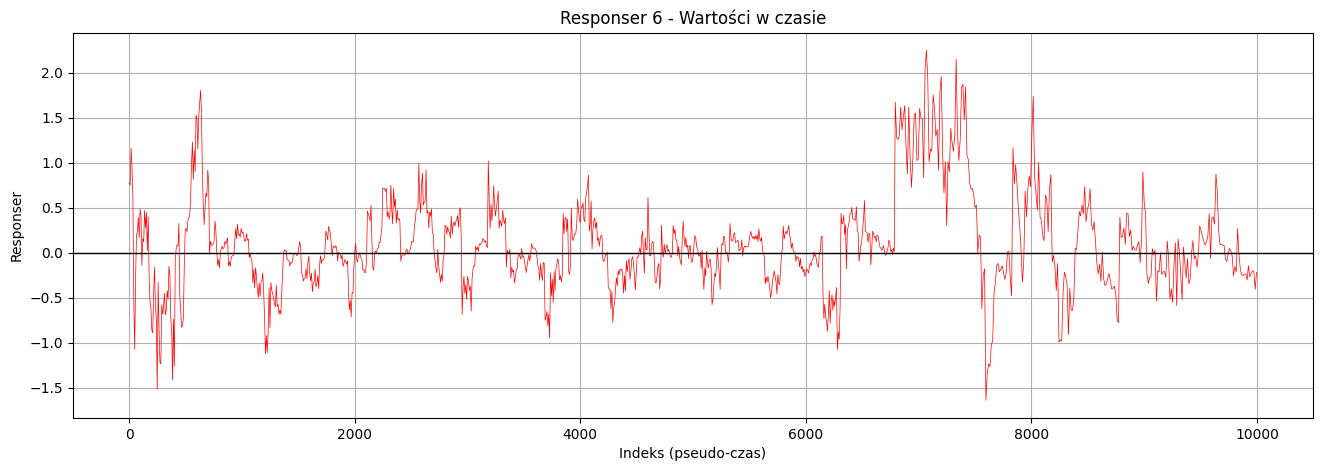

In [60]:
filtered_data = sample_df[sample_df['symbol_id'] == 1]

xx = filtered_data.index
yy = filtered_data['responder_6']

# Wykres Responsera 6 w czasie
plt.figure(figsize=(16, 5))
plt.plot(xx, yy, color='red', linewidth=0.5)
plt.title('Responser 6 - Wartości w czasie')
plt.xlabel('Indeks (pseudo-czas)')
plt.ylabel('Responser')
plt.grid(True)
plt.axhline(0, color='black', linestyle='-', linewidth=1)
plt.show()

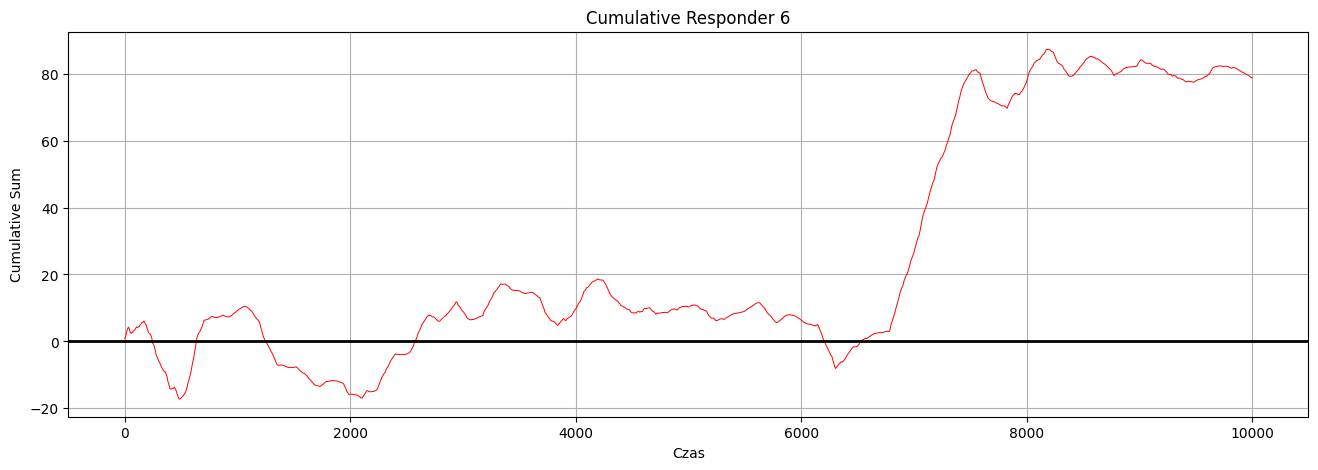

In [61]:
# Wizualizacja skumulowanego Responsera 6
yy_cumsum = yy.cumsum()

plt.figure(figsize=(16, 5))
plt.plot(xx, yy_cumsum, color='red', linewidth=0.7)
plt.title('Cumulative Responder 6')
plt.xlabel('Czas')
plt.ylabel('Cumulative Sum')
plt.axhline(0, color='black', linestyle='-', linewidth=2.0)
plt.grid(True)
plt.show()

PRZETWARZANIE WSADU (Batch processing)

In [32]:
# Przetwarzanie pojedynczego wsadu
def process_batch(batch):
    df = batch.compute()  
    df.fillna(0, inplace=True)  
    return df

def prepare_data(batch_df):
    # Utworzenie lagów dla kolumn responder
    for idx in range(9):  # 9 responders
        col_name = f"responder_{idx}"
        lag_col_name = f"{col_name}_lag_1"
        if col_name in batch_df.columns:
            batch_df[lag_col_name] = batch_df[col_name].shift(1) 
        else:
            print(f"Kolumna {col_name} nie istnieje w danych wsadu.")

    # Wypełnienie braków zerami
    batch_df.fillna(0, inplace=True)

    # średnie ruchome dla kolumn feature
    for idx in range(79):  # 79 cech wejściowych
        feature_col = f"feature_{idx:02d}"
        rolling_col_name = f"{feature_col}_mvg_avg"
        if feature_col in batch_df.columns:
            batch_df[rolling_col_name] = batch_df[feature_col].rolling(window=7, min_periods=1).mean()
        else:
            print(f"Kolumna {feature_col} nie istnieje w danych wsadu.")
            
    return batch_df

batches = sample_ddf.to_delayed()
process_batches(batches)

Rozmiar wsadu 1: (833232, 93)
Rozmiar wsadu 2: (833232, 93)


- przetwarzanie danych w batchach, aby obliczenia zjadały mniej RAMu
- w czasie uczenia model będzie korzystał z opóźnionych (lagowanych) wartości wcześniejszych odpowiedzi by przewidywać aktualny stan (funkcja dodaje każdej zmiennej odpowiadającej responderom_0-8 opóźnioną wartość z poprzedniego kroku lag_1
- średnie ruchome: dla cech (feature), które są sekwencjami czasowymi obliczane są średnie ruchome na przestrzeni okna czasowego równego 7 dni aby usunąć krótkoterminowe fluktuacje i wykywać trendy
- zastępowanie brakujących danych zerami  

PRZYGOTOWANIE MODELU LSTM (Long Short-Term Memory)

In [46]:
def lstm_model(input_dimension, time_steps, features):
    # Wejście
    symbol_id_input = keras.Input(shape=(time_steps, 1), name='symbol_id')  # Reprezentacja czasowa
    num_input = keras.Input(shape=(time_steps, features), name='num_data')  # szereg czasowy
    
    # Warstwy LSTM
    x = layers.LSTM(64, return_sequences=True)(num_input)
    x = layers.Dropout(0.2)(x)  
    x = layers.LSTM(64)(x)
    x = layers.Dropout(0.2)(x)  

    # Warstwa wyjściowa
    out = layers.Dense(1, activation='linear', name='prediction')(x)

    # Model
    model = Model(inputs=[symbol_id_input, num_input], outputs=out)
    return model

Zbudowany model LSTM (sieć neuronowa do analizy danych szeregów czasowych):
- symbol_id_input (wejście) pole reprezentujące cechę (symbol) w czasie
- num_input (wejście): cechy wejściowe - szereg czasowy
- warstwy LSTM -> zapamiętywanie i uzywanie informacji z poprzednich kroków czasowych
- Dropout: dodajemy aby uniknąc przeuczenia modelu (celowe pomijanie neuronów)
- Dense (w. wyjściowa): zwraca wartość predykcji

TRENING

In [62]:
def train_model_in_batches():
    batches = sample_ddf.to_delayed()

    feature_columns = [f"feature_{idx:02d}" for idx in range(79)]  # 79 cech pierwotnych
    lag_columns = [f"responder_{idx}_lag_1" for idx in range(9)]  # 9 lagów
    rolling_columns = [f"feature_{idx:02d}_mvg_avg" for idx in range(3)]  # 3 średnie ruchome
    selected_columns = feature_columns + lag_columns + rolling_columns
    
    for batch_idx, batch in enumerate(batches[:5]):
        print(f"Przetwarzanie wsadu {batch_idx + 1}...")

        # Przetwarzanie wsadu
        batch_df = process_batch(batch)
        batch_df = prepare_data(batch_df)

        # brakujace kolumny
        missing_columns = [col for col in selected_columns if col not in batch_df.columns]
        if missing_columns:
            raise ValueError(f"Brakujące kolumny w danych wsadu: {missing_columns}")
        
        # Kolumny ekstra
        # extra_columns = [col for col in batch_df.columns if col not in selected_columns + ["responder_6", "symbol_id"]]
        # if extra_columns:
        #     print(f"nadmiarowe kolumny (pomijane): {extra_columns}")

        # Selekcja kolumn
        X_train = batch_df[selected_columns]
        
        # Zmienne wejściowe
        Y_train = batch_df["responder_6"]
        X_embedding_np = batch_df["symbol_id"].values  

        # Przekształcenie symbol_id, aby miało kształt (batch_size, 1) dodanie wymiaru
        X_embedding_np = np.expand_dims(X_embedding_np, axis=1)  

        # Przekształcenie na formę czasową (3D dla LSTM)
        time_steps = 1  # 1 krok czasowy
        X_train_lstm = np.expand_dims(X_train.values, axis=1)  # zmiana wymiarow (batch_size, 1, features)
        
        input_dimension = int(X_embedding_np.max() + 1)
        model = lstm_model(input_dimension, time_steps, len(selected_columns))

        model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss="mse", metrics=["mae"])
        
        # Callback dla redukcji tempa nauki
        lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=2, verbose=1)

        # Trening modelu
        model.fit(
            [X_embedding_np, X_train_lstm], Y_train,
            batch_size=batch_size,
            epochs=10,  
            validation_split=0.2,  
            callbacks=[lr_scheduler],  
            verbose=1
        )

        print(f"Trening dla wsadu {batch_idx + 1} zakończony.")
        gc.collect()


Funkcja do trenowania modelu w partiach (batchach) aby uniknąc nadmiernego wykorzystania RAMu.
- to_delayed() -> ładowanie partii danych co iteracje, ograniczając dostaraczanie zbt dużej ilość danych na raz
- selekcja cech: wybranie kolumn z cechami (feature_00-78), lagami (9) i średnimi ruchomymi (3) dla modelu (łącznie 91)
- dane wejściowe i wyjściowe - X_train (cechy) i Y_train (responder_6)
- dla LSTM dane muszą być w formie trójwymiarowej (batch_size, time_steps, features)
- trening + ReduceLROnPlauteau do automatycznego dopasowywania learning_rate

In [63]:
train_model_in_batches()

Przetwarzanie wsadu 1...
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - loss: 0.6626 - mae: 0.5202 - val_loss: 0.6632 - val_mae: 0.5162 - learning_rate: 1.0000e-04
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - loss: 0.6598 - mae: 0.5191 - val_loss: 0.6635 - val_mae: 0.5155 - learning_rate: 1.0000e-04
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - loss: 0.6600 - mae: 0.5186 - val_loss: 0.6635 - val_mae: 0.5153 - learning_rate: 1.0000e-04
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: 0.6608 - mae: 0.5188 - val_loss: 0.6632 - val_mae: 0.5153 - learning_rate: 1.0000e-04
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: 0.6584 - mae: 0.5176 - val_loss: 0.6631 - val_mae: 0.5154 - learning_rate: 1.0000e-04
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: 0.6596 - mae: 0.5179 - val_loss: 0.6631 - val_mae: 0.5154 - learning_rate: 1.0000e-04
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: 0.6583 - mae: 0.5179 - val_loss: 0.6632 - val_mae: 0.5153 - learnin

Wnioski:
- loss i mae (średni błąd bezwzględny) mają trend stagnacyjny - wartości pozostają stabilne, ew. zmniejszając się nieznacznie -> model nie uczy się efektywnie
Co poprawić? modyfikacja szybkości uczenia, jakość danych, epok, konfiguracja modelu, zmiana metody optymalizacji (np. Adam, RMSprop)